In [6]:
import json
import pandas as pd
from shapely.geometry import shape, Point
import re
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from my_functions import Distance_Data
%load_ext autoreload
%autoreload 2

# Get 1400 random postal codes in Singapore to predict

In [53]:
# Load the GeoJSON file with polygon data
with open('data/master-plan-2019-subzone-boundary-no-sea-geojson.geojson') as f:
    polygons = json.load(f)
# Convert the GeoJSON features to Shapely polygons
polygons_coord = [shape(feature['geometry']) for feature in polygons['features']]

In [54]:
subzone_names = []
for i in range(len(polygons_coord)):
    string = polygons['features'][i]['properties']['Description']
    
    # Define regex pattern to extract text between "<td>" and "</td>" tags that follow "<th>SUBZONE_N</th>"
    pattern = r'<th>SUBZONE_N<\/th>\s*<td>(.*?)<\/td>'

    # Use regex search function to extract text from the string
    match = re.search(pattern, string)

    # Extract the text from the match object
    if match:
        extracted_text = match.group(1)
        subzone_names.append(extracted_text)
    else:
        print("No match found.")

In [55]:
len(subzone_names)

332

In [56]:
# extract all latitudes and longitudes from the json file
with open('data/database.json') as f:
    data = json.load(f)
    latitudes = [float(x['LATITUDE']) for x in data]
    longitudes = [float(x['LONGITUDE']) for x in data]

In [57]:
# put into a dataframe and save as csv
df = pd.DataFrame({'latitude': latitudes, 'longitude': longitudes})

In [58]:
df.head()

,latitude,longitude
0,1.28,103.85
1,1.27,103.85
2,1.28,103.87
3,1.28,103.85
4,1.28,103.85


In [59]:
# check if each point is in each polygon and assign the respective subzone name
for i, row in df.iterrows():
    point = Point(row['longitude'], row['latitude'])
    for j, polygon in enumerate(polygons_coord):
        if polygon.contains(point):
            df.loc[i, 'polygon'] = subzone_names[j]
            break

In [60]:
df.head()

,latitude,longitude,polygon
0,1.28,103.85,CECIL
1,1.27,103.85,CENTRAL SUBZONE
2,1.28,103.87,MARINA SOUTH
3,1.28,103.85,CENTRAL SUBZONE
4,1.28,103.85,CENTRAL SUBZONE


In [61]:
# drop empty rows
df = df.dropna()

In [63]:
# export to csv
df.to_csv('data/sg_coordinates.csv', index=False)

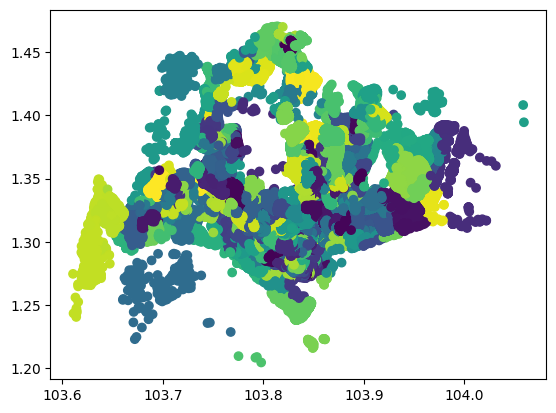

In [94]:
fig, ax = plt.subplots()
ax.scatter(df['longitude'], df['latitude'], c=df['polygon'].astype('category').cat.codes, cmap='viridis')

repeat the same process for feature engineering for the model

In [64]:
# file path
csv = 'data/traffic_data.csv'

# import data to csv
traffic_df = pd.read_csv(csv,index_col=0)

# convert column to correct data type
traffic_df['PT_CODE']=traffic_df['PT_CODE'].astype('str')

# for each value in PT_code find out the length
traffic_df['PT_CODE_LEN'] = traffic_df['PT_CODE'].apply(lambda x: len(x))
print(traffic_df['PT_CODE_LEN'].value_counts())

# if length of PT_CODE is 4, add a 0 in front
traffic_df['PT_CODE'] = traffic_df['PT_CODE'].apply(lambda x: '0' + x if len(x) == 4 else x)

traffic_df['PT_CODE_LEN'] = traffic_df['PT_CODE'].apply(lambda x: len(x))
print()
print(traffic_df['PT_CODE_LEN'].value_counts())
print('converted all PT_CODE to 5 digits')

# drop the PT_CODE_LEN column
traffic_df.drop('PT_CODE_LEN', axis=1, inplace=True)

print()
print(traffic_df.head())

5    750212
4     35776
Name: PT_CODE_LEN, dtype: int64

5    785988
Name: PT_CODE_LEN, dtype: int64
converted all PT_CODE to 5 digits

  YEAR_MONTH          DAY_TYPE  TIME_PER_HOUR PT_CODE  TOTAL_TAP_IN_VOLUME  \
0    2022-11           WEEKDAY             17   45379                  375   
1    2022-11  WEEKENDS/HOLIDAY             17   45379                  142   
2    2022-11  WEEKENDS/HOLIDAY             13   80051                  965   
3    2022-11           WEEKDAY             13   80051                 2329   
4    2022-11  WEEKENDS/HOLIDAY              8   03511                   50   

   TOTAL_TAP_OUT_VOLUME  
0                   368  
1                   102  
2                   902  
3                  2319  
4                   133  


In [65]:
# file path
csv = 'data/bus_stops.csv'

# import data to csv
stops_df = pd.read_csv(csv, index_col=0)

# convert column to correct data type
stops_df['BusStopCode']=stops_df['BusStopCode'].astype('str')

# for each value in BusStopCode find out the length
stops_df['BusStopCode_LEN'] = stops_df['BusStopCode'].apply(lambda x: len(x))
print(stops_df['BusStopCode_LEN'].value_counts())

# if length of BusStopCode is 4, add a 0 in front
stops_df['BusStopCode'] = stops_df['BusStopCode'].apply(lambda x: '0' + x if len(x) == 4 else x)

stops_df['BusStopCode_LEN'] = stops_df['BusStopCode'].apply(lambda x: len(x))
print()
print(stops_df['BusStopCode_LEN'].value_counts())
print('converted all BusStopCode to 5 digits')
# drop the BusStopCode_LEN column
stops_df.drop('BusStopCode_LEN', axis=1, inplace=True)

stops_df = stops_df.drop(columns=['RoadName','Description'])
stops_df['BusStopCode']=stops_df['BusStopCode'].astype(str)

pd.set_option('display.float_format', lambda x: '%.5f' % x)
print()
print(stops_df.head())
pd.set_option('display.float_format', lambda x: '%.2f' % x)

5    4851
4     232
Name: BusStopCode_LEN, dtype: int64

5    5083
Name: BusStopCode_LEN, dtype: int64
converted all BusStopCode to 5 digits

  BusStopCode  Latitude  Longitude
0       01012   1.29685  103.85254
1       01013   1.29771  103.85322
2       01019   1.29699  103.85302
3       01029   1.29667  103.85441
4       01039   1.29821  103.85549


### append the bus traffic data

In [66]:
# merge stops and traffic
stops_traffic_df = pd.merge(traffic_df, stops_df, right_on='BusStopCode', left_on='PT_CODE',how='left')

In [67]:
# manually impute PT_CODE 98231 with latitude and longitude numbers
# https://businterchange.net/sgbus/stops/busstop.php?stop=98231
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98231','Latitude']=1.3712054765689932 
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98231','Longitude']=103.97183863961368

# https://businterchange.net/sgbus/stops/busstop.php?stop=98239
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98239','Latitude']=1.3715083131923107 
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98239','Longitude']=103.97261543551689

# https://businterchange.net/sgbus/stops/busstop.php?stop=40189
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='40189','Latitude']=1.312394537329837  
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='40189','Longitude']=103.83917866460602

# https://businterchange.net/sgbus/stops/busstop.php?stop=98059
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98059','Latitude']=1.3733394338087794  
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98059','Longitude']=103.9746197614457

# https://businterchange.net/sgbus/stops/busstop.php?stop=98051
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98051','Latitude']=1.3731678217387
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98051','Longitude']=103.9746734056245

# https://businterchange.net/sgbus/stops/busstop.php?stop=98031
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98031','Latitude']=1.3802596577286035 
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98031','Longitude']=103.94264233700554

# https://businterchange.net/sgbus/stops/busstop.php?stop=98039
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98039','Latitude']=1.367588514611644
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98039','Longitude']=103.96888269398227

In [68]:
# rename columns to to make it more user friendly
stops_traffic_df.rename(columns={'Latitude':'latitude','Longitude':'longitude'}, inplace=True)
stops_traffic_df.rename(columns={b'TOTAL_TAP_IN_VOLUME':'in','TOTAL_TAP_OUT_VOLUME':'out'}, inplace=True)

# replace / in DAY_TYPE column with _
stops_traffic_df['DAY_TYPE'] = stops_traffic_df['DAY_TYPE'].str.replace('/','_')

In [69]:
# rename columns to to make it more user friendly
stops_traffic_df.rename(columns={'Latitude':'latitude','Longitude':'longitude'}, inplace=True)
stops_traffic_df.rename(columns={'TOTAL_TAP_IN_VOLUME':'in','TOTAL_TAP_OUT_VOLUME':'out'}, inplace=True)

# replace / in DAY_TYPE column with _
stops_traffic_df['DAY_TYPE'] = stops_traffic_df['DAY_TYPE'].str.replace('/','_')

In [70]:
# get dataframe of PT_CODE by latitude and longitude to check against each McDonalds location
location_df = stops_traffic_df[['PT_CODE','latitude','longitude']].drop_duplicates()
# sort index by PT_CODE
location_df.sort_values(by='PT_CODE', inplace=True)
# reset index values
location_df.reset_index(drop=True, inplace=True)

# inspect location_df
print(location_df.head())
location_df.shape

  PT_CODE  latitude  longitude
0   01012      1.30     103.85
1   01013      1.30     103.85
2   01019      1.30     103.85
3   01029      1.30     103.85
4   01039      1.30     103.86


(5082, 3)

In [71]:
# create a new 96 x 5082 matrix for 96 types of traffic data (2 traffic type (in, out) x 2 day type (weekday, weekend) x 24 hours) against 5082 bus stops

# pivot the dataframe to reshape it
bus_data = stops_traffic_df.pivot_table(index='PT_CODE', columns=['DAY_TYPE', 'TIME_PER_HOUR'], values=['in', 'out'], aggfunc='sum')

# flatten the column index
bus_data.columns = [f'{col[1]}_{col[2]}_{col[0]}' for col in bus_data.columns]

column_list = bus_data.columns.tolist()

# tranpose the dataframe 
bus_data = bus_data.T

# transform it into a numpy array of a 96 x 5082 matrix
bus_data = bus_data.to_numpy()

# fill nan with 0
bus_data = np.nan_to_num(bus_data)

# print the new dataframe
print(f'the shape of the {type(bus_data)} is {bus_data.shape}')
print('inspecting some values...')
print(bus_data)

# rows: 96 weekday/weekends_holiday + 0-23 hours + in/out 
# columns: 5082 bus stops arranged in numerical order

the shape of the <class 'numpy.ndarray'> is (96, 5082)
inspecting some values...
[[938. 227. 220. ...   6. 378.  29.]
 [  4.   0.   0. ...   0.   0.  10.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [896. 532. 432. ...  35. 301. 267.]
 [813. 434. 386. ...  27. 202. 267.]
 [430. 298. 269. ...  23. 106. 114.]]


In [72]:
# delete 90% of rows from df stratified by polygon
pct_to_delete = 0.99

# create an empty list to store the rows to keep
rows_to_keep = []

category_counts = df['polygon'].value_counts()

# iterate through each category
for category, count in category_counts.iteritems():
    # determine the number of rows to keep for this category
    rows_to_keep_for_category = int((1 - pct_to_delete) * count)
    # randomly select the rows to keep for this category
    category_rows = df.loc[df['polygon'] == category]
    selected_rows = category_rows.sample(n=rows_to_keep_for_category, random_state=42)
    # add the selected rows to the list of rows to keep
    rows_to_keep.append(selected_rows)

# concatenate the selected rows for each category into a single dataframe
df_selected = pd.concat(rows_to_keep)

# print the selected dataframe
print(df_selected)

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_21672/1909669413.py:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for category, count in category_counts.iteritems():


       latitude  longitude                     polygon
65671      1.31     103.92                     FRANKEL
62861      1.32     103.92                     FRANKEL
65899      1.31     103.92                     FRANKEL
65979      1.31     103.92                     FRANKEL
65285      1.31     103.93                     FRANKEL
...         ...        ...                         ...
96857      1.36     103.85                  TOWNSVILLE
36713      1.34     103.85              TOA PAYOH WEST
39257      1.32     103.87               GEYLANG BAHRU
98421      1.38     103.86  SERANGOON NORTH IND ESTATE
824        1.29     103.85                CHINA SQUARE

[1273 rows x 3 columns]


In [73]:
# reset index of df
df_selected.reset_index(drop=True, inplace=True)

In [74]:
distance_list = [2,1,0.5,0.2]

In [75]:
# multiply the bus_data 96 x 5082 matrix by a 5082 x 4 (distance_list) matrix to get a 96 x 4 matrix for each Coordinates
coord_list = Distance_Data(df).traffic_count(df_selected,location_df,bus_data,distance_list)

Number of McDonalds done: 1
Number of McDonalds done: 2
Number of McDonalds done: 3
Number of McDonalds done: 4
Number of McDonalds done: 5
Number of McDonalds done: 6
Number of McDonalds done: 7
Number of McDonalds done: 8
Number of McDonalds done: 9
Number of McDonalds done: 10
Number of McDonalds done: 11
Number of McDonalds done: 12
Number of McDonalds done: 13
Number of McDonalds done: 14
Number of McDonalds done: 15
Number of McDonalds done: 16
Number of McDonalds done: 17
Number of McDonalds done: 18
Number of McDonalds done: 19
Number of McDonalds done: 20
Number of McDonalds done: 21
Number of McDonalds done: 22
Number of McDonalds done: 23
Number of McDonalds done: 24
Number of McDonalds done: 25
Number of McDonalds done: 26
Number of McDonalds done: 27
Number of McDonalds done: 28
Number of McDonalds done: 29
Number of McDonalds done: 30
Number of McDonalds done: 31
Number of McDonalds done: 32
Number of McDonalds done: 33
Number of McDonalds done: 34
Number of McDonalds don

In [76]:
len(column_list)

96

In [77]:
# for each value in column_list, append distance_list to the end of the column name to get 96 x 4 = 384 features
column_list = [f'{col}_{distance}' for col in column_list for distance in distance_list]

In [78]:
df_selected.shape

(1273, 3)

In [79]:
df_selected = pd.concat([df_selected, pd.DataFrame(coord_list, columns=column_list)], axis=1)

In [80]:
# export df_selected_new
df_selected.to_csv('data/df_selected.csv', index=False)

## append the subzone data

In [81]:
# import df selected
df_selected = pd.read_csv('data/df_selected.csv')

In [82]:
# import the subzone data
sz_pop_area_df = pd.read_csv('data/sz_pop_area.csv',index_col=0)
# ignore index when importing the income data
sz_income_df = pd.read_csv('data/sz_income.csv')

In [83]:
sz_pop_area_df.head()

,Hse,subzone,area,density
0,4670,ADMIRALTY,1.03,4554.78
1,0,AIRPORT ROAD,0.39,0.00
2,5430,ALEXANDRA HILL,0.84,6485.17
3,1870,ALEXANDRA NORTH,0.24,7835.43
4,22590,ALJUNIED,2.41,9386.94


In [84]:
sz_income_df.head()

,SZ,sz_income
0,ADMIRALTY,18900.00
1,AIRPORT ROAD,0.00
2,ALEXANDRA HILL,15330.00
3,ALEXANDRA NORTH,13090.00
4,ALJUNIED,116930.00


In [85]:
# merge all sz and pa df with mcd_df based on planning_area and subzone
df_selected = df_selected.merge(sz_pop_area_df, how='left', left_on='polygon', right_on='subzone')
df_selected = df_selected.merge(sz_income_df, how='left', left_on='polygon', right_on='SZ')

In [86]:
df_selected.rename(columns={'Hse':'sz_pop', 'area':'sz_area','density':'sz_density'}, inplace=True)

In [87]:
df_selected

,latitude,longitude,polygon,WEEKDAY_0_in_2,WEEKDAY_0_in_1,WEEKDAY_0_in_0.5,WEEKDAY_0_in_0.2,WEEKDAY_1_in_2,WEEKDAY_1_in_1,WEEKDAY_1_in_0.5,...,WEEKENDS_HOLIDAY_23_out_2,WEEKENDS_HOLIDAY_23_out_1,WEEKENDS_HOLIDAY_23_out_0.5,WEEKENDS_HOLIDAY_23_out_0.2,sz_pop,subzone,sz_area,sz_density,SZ,sz_income
0,1.31,103.92,FRANKEL,22077.00,1240.00,939.00,419.00,411.00,37.00,32.00,...,58936.00,6642.00,3340.00,488.00,13700,FRANKEL,3.49,3923.34,FRANKEL,101170.00
1,1.32,103.92,FRANKEL,24317.00,2963.00,372.00,3.00,495.00,132.00,17.00,...,72281.00,11804.00,844.00,128.00,13700,FRANKEL,3.49,3923.34,FRANKEL,101170.00
2,1.31,103.92,FRANKEL,27271.00,1721.00,162.00,0.00,787.00,44.00,6.00,...,61614.00,11321.00,982.00,0.00,13700,FRANKEL,3.49,3923.34,FRANKEL,101170.00
3,1.31,103.92,FRANKEL,27329.00,2980.00,79.00,2.00,794.00,81.00,5.00,...,66174.00,11832.00,486.00,96.00,13700,FRANKEL,3.49,3923.34,FRANKEL,101170.00
4,1.31,103.93,FRANKEL,19815.00,1369.00,358.00,8.00,395.00,55.00,23.00,...,52370.00,5775.00,2345.00,350.00,13700,FRANKEL,3.49,3923.34,FRANKEL,101170.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,1.36,103.85,TOWNSVILLE,30333.00,20375.00,752.00,78.00,2065.00,1396.00,87.00,...,82310.00,43075.00,5600.00,443.00,8040,TOWNSVILLE,0.44,18107.38,TOWNSVILLE,27880.00
1269,1.34,103.85,TOA PAYOH WEST,23724.00,11320.00,1388.00,993.00,491.00,16.00,4.00,...,77784.00,27257.00,3611.00,1268.00,6120,TOA PAYOH WEST,0.84,7260.47,TOA PAYOH WEST,24190.00
1270,1.32,103.87,GEYLANG BAHRU,36401.00,8533.00,238.00,10.00,1123.00,266.00,3.00,...,107268.00,30850.00,4385.00,60.00,4430,GEYLANG BAHRU,0.60,7411.95,GEYLANG BAHRU,13380.00
1271,1.38,103.86,SERANGOON NORTH IND ESTATE,26071.00,1644.00,210.00,22.00,1676.00,86.00,1.00,...,75203.00,14723.00,1438.00,28.00,0,SERANGOON NORTH IND ESTATE,0.75,0.00,SERANGOON NORTH IND ESTATE,0.00


In [88]:
# save df_selected to csv
df_selected.to_csv('data/df_selected.csv', index=False)

### append the hdb count data

In [89]:
distance_list = [2,1,0.5,0.2]

In [90]:
# import hdb_df.csv
hdb_df = pd.read_csv('data/hdb_df.csv')

In [91]:
hdb_df

,blk_no,street,max_floor_lvl,year_completed,residential,commercial,market_hawker,miscellaneous,multistorey_carpark,precinct_pavilion,...,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,address,latitude,longitude,polygon
0,1,BEACH RD,16,1970,Y,Y,N,N,N,N,...,0,0,0,0,0,0,1 BEACH RD,1.30,103.85,CITY HALL
1,1,BEDOK STH AVE 1,14,1975,Y,N,N,Y,N,N,...,0,0,0,0,0,0,1 BEDOK STH AVE 1,1.32,103.93,BEDOK SOUTH
2,1,CANTONMENT RD,2,2010,N,Y,N,N,N,N,...,0,0,0,0,0,0,1 CANTONMENT RD,1.28,103.84,CHINATOWN
3,1,CHAI CHEE RD,15,1982,Y,N,N,N,N,N,...,0,0,0,0,0,0,1 CHAI CHEE RD,1.33,103.92,KEMBANGAN
4,1,CHANGI VILLAGE RD,4,1975,Y,Y,N,N,N,N,...,0,0,0,0,0,0,1 CHANGI VILLAGE RD,1.39,103.99,CHANGI POINT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12621,998A,BUANGKOK CRES,18,2018,Y,N,N,N,N,N,...,0,0,0,0,0,0,998A BUANGKOK CRES,1.38,103.88,TRAFALGAR
12622,998B,BUANGKOK CRES,17,2018,Y,N,N,N,N,N,...,0,0,0,0,0,0,998B BUANGKOK CRES,1.38,103.88,TRAFALGAR
12623,999,BUANGKOK CRES,2,2018,N,N,N,Y,N,Y,...,0,0,0,0,0,0,999 BUANGKOK CRES,1.38,103.88,TRAFALGAR
12624,999A,BUANGKOK CRES,18,2018,Y,N,N,N,N,N,...,0,0,136,170,0,0,999A BUANGKOK CRES,1.38,103.88,TRAFALGAR


In [93]:
# Get the num_hdb feature data
for i in distance_list:
    print(f'This is the run for distance {i}km')
    
    # this function initiates the dataframe based on the length of mcd_df and then computes the number of X within the distance
    # the columns of the item to be counted must be 'latitude' and 'longitude'
    result = Distance_Data(df_selected).num_count(i,df_selected,hdb_df,'hdb_count')

    # save the data to csv
    result.to_csv(f'hdb_{i}.csv', index=False)
    print(f'Successfully finished for distance {i}km')

This is the run for distance 2km
Successfully finished for distance 2km
This is the run for distance 1km
Successfully finished for distance 1km
This is the run for distance 0.5km
Successfully finished for distance 0.5km
This is the run for distance 0.2km
Successfully finished for distance 0.2km


In [ ]:
# merge the files
pd.read_csv('data/df_selected.csv')

# Do the predictions

In [94]:
features = ['WEEKDAY_7_in_2', 'WEEKENDS_HOLIDAY_22_out_0.5', 'WEEKDAY_6_in_0.5', 'WEEKDAY_0_out_0.5', 'WEEKDAY_5_in_0.5', 'WEEKDAY_23_out_0.5', 'WEEKENDS_HOLIDAY_6_in_0.5', 'sz_income', 'WEEKENDS_HOLIDAY_11_in_0.5', 'WEEKDAY_21_out_1', 'WEEKDAY_22_out_1', 'sz_pop', 'hdb_count1', 'WEEKENDS_HOLIDAY_1_in_2', 'WEEKENDS_HOLIDAY_8_in_0.5', 'WEEKDAY_23_out_1', 'WEEKENDS_HOLIDAY_10_in_0.5', 'WEEKENDS_HOLIDAY_3_in_2', 'WEEKENDS_HOLIDAY_21_out_0.5', 'WEEKENDS_HOLIDAY_5_in_0.5', 'WEEKENDS_HOLIDAY_23_out_1', 'WEEKENDS_HOLIDAY_0_out_1', 'WEEKENDS_HOLIDAY_2_out_0.2', 'WEEKENDS_HOLIDAY_23_out_0.5', 'WEEKENDS_HOLIDAY_2_out_0.5', 'WEEKENDS_HOLIDAY_1_out_2', 'WEEKDAY_10_in_0.5', 'WEEKDAY_22_out_0.5', 'WEEKDAY_6_in_2', 'WEEKDAY_20_out_0.5', 'WEEKDAY_0_out_1', 'sz_density', 'WEEKDAY_1_in_1', 'WEEKENDS_HOLIDAY_1_out_1', 'WEEKDAY_1_in_2', 'WEEKENDS_HOLIDAY_3_out_0.5', 'WEEKDAY_1_out_2', 'hdb_count0.2', 'WEEKENDS_HOLIDAY_22_out_1', 'WEEKENDS_HOLIDAY_8_in_1', 'WEEKDAY_21_out_0.5', 'hdb_count0.5', 'WEEKENDS_HOLIDAY_0_out_0.5', 'WEEKENDS_HOLIDAY_9_in_0.5', 'classification']

In [96]:
['WEEKDAY_7_in_2', 'WEEKENDS_HOLIDAY_22_out_0.5', 'WEEKDAY_6_in_0.5', 'WEEKDAY_0_out_0.5', 'WEEKDAY_5_in_0.5', 'WEEKDAY_23_out_0.5', 'WEEKENDS_HOLIDAY_6_in_0.5', 'sz_income', 'WEEKENDS_HOLIDAY_11_in_0.5', 'WEEKDAY_21_out_1', 'WEEKDAY_22_out_1', 'sz_pop', 'hdb_count1', 'WEEKENDS_HOLIDAY_1_in_2', 'WEEKENDS_HOLIDAY_8_in_0.5', 'WEEKDAY_23_out_1', 'WEEKENDS_HOLIDAY_10_in_0.5', 'WEEKENDS_HOLIDAY_3_in_2', 'WEEKENDS_HOLIDAY_21_out_0.5', 'WEEKENDS_HOLIDAY_5_in_0.5', 'WEEKENDS_HOLIDAY_23_out_1', 'WEEKENDS_HOLIDAY_0_out_1', 'WEEKENDS_HOLIDAY_2_out_0.2', 'WEEKENDS_HOLIDAY_23_out_0.5', 'WEEKENDS_HOLIDAY_2_out_0.5', 'WEEKENDS_HOLIDAY_1_out_2', 'WEEKDAY_10_in_0.5', 'WEEKDAY_22_out_0.5', 'WEEKDAY_6_in_2', 'WEEKDAY_20_out_0.5', 'WEEKDAY_0_out_1', 'sz_density', 'WEEKDAY_1_in_1', 'WEEKENDS_HOLIDAY_1_out_1', 'WEEKDAY_1_in_2', 'WEEKENDS_HOLIDAY_3_out_0.5', 'WEEKDAY_1_out_2', 'hdb_count0.2', 'WEEKENDS_HOLIDAY_22_out_1', 'WEEKENDS_HOLIDAY_8_in_1', 'WEEKDAY_21_out_0.5', 'hdb_count0.5', 'WEEKENDS_HOLIDAY_0_out_0.5', 'WEEKENDS_HOLIDAY_9_in_0.5', 'classification']

['WEEKDAY_7_in_2',
 'WEEKENDS_HOLIDAY_22_out_0.5',
 'WEEKDAY_6_in_0.5',
 'WEEKDAY_0_out_0.5',
 'WEEKDAY_5_in_0.5',
 'WEEKDAY_23_out_0.5',
 'WEEKENDS_HOLIDAY_6_in_0.5',
 'sz_income',
 'WEEKENDS_HOLIDAY_11_in_0.5',
 'WEEKDAY_21_out_1',
 'WEEKDAY_22_out_1',
 'sz_pop',
 'hdb_count1',
 'WEEKENDS_HOLIDAY_1_in_2',
 'WEEKENDS_HOLIDAY_8_in_0.5',
 'WEEKDAY_23_out_1',
 'WEEKENDS_HOLIDAY_10_in_0.5',
 'WEEKENDS_HOLIDAY_3_in_2',
 'WEEKENDS_HOLIDAY_21_out_0.5',
 'WEEKENDS_HOLIDAY_5_in_0.5',
 'WEEKENDS_HOLIDAY_23_out_1',
 'WEEKENDS_HOLIDAY_0_out_1',
 'WEEKENDS_HOLIDAY_2_out_0.2',
 'WEEKENDS_HOLIDAY_23_out_0.5',
 'WEEKENDS_HOLIDAY_2_out_0.5',
 'WEEKENDS_HOLIDAY_1_out_2',
 'WEEKDAY_10_in_0.5',
 'WEEKDAY_22_out_0.5',
 'WEEKDAY_6_in_2',
 'WEEKDAY_20_out_0.5',
 'WEEKDAY_0_out_1',
 'sz_density',
 'WEEKDAY_1_in_1',
 'WEEKENDS_HOLIDAY_1_out_1',
 'WEEKDAY_1_in_2',
 'WEEKENDS_HOLIDAY_3_out_0.5',
 'WEEKDAY_1_out_2',
 'hdb_count0.2',
 'WEEKENDS_HOLIDAY_22_out_1',
 'WEEKENDS_HOLIDAY_8_in_1',
 'WEEKDAY_21_out_0.5',

In [ ]:
df_selected[features]